In [36]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [37]:
img_list=[]
files = os.listdir("C:/Users/pc/Desktop/DiaRet/step4/train_images")
for i in files[::]:
    image = cv2.imread(f"C:/Users/pc/Desktop/DiaRet/step4/train_images/{i}")
    image = cv2.resize(image,(400,400))
    image = image[:,:,1]
    kopya = image.copy()
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thold = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kenar = cv2.findContours(thold.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kenar = kenar[0][0]
    kenar = kenar[:,0,:]
    x1 = tuple(kenar[kenar[:,0].argmin()])[0]
    y1 = tuple(kenar[kenar[:,1].argmin()])[1]
    x2 = tuple(kenar[kenar[:,0].argmax()])[0]
    y2 = tuple(kenar[kenar[:,1].argmin()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*4//50
    kopya2 = image.copy()
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    clahe = cv2.createCLAHE(clipLimit = 5.0,tileGridSize=((8,8)))
    cl = clahe.apply(kopya2)
    med_resim = cv2.medianBlur(kopya2,3)
    arka_plan = cv2.medianBlur(kopya2,33)
    maske = cv2.addWeighted(med_resim,1,arka_plan,-1,255)
    maske_resim = cv2.bitwise_and(maske,med_resim)
    img_list.append(maske_resim)
    

In [38]:
df = pd.read_csv("C:/Users/pc/Desktop/DiaRet/step4/train.csv")
y_train = pd.get_dummies(df["diagnosis"]).values.astype(int)
x_train = np.array(img_list)

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.15,random_state=42,shuffle = True)

In [40]:
y_train = np.argmax(y_train, axis=1)  
y_test = np.argmax(y_test, axis=1)

In [41]:
import numpy as np

x_train = np.repeat(np.expand_dims(x_train, axis=-1), 3, axis=-1)
x_test = np.repeat(np.expand_dims(x_test, axis=-1), 3, axis=-1)

print(x_train.shape) 
print(x_test.shape)  

(329, 400, 400, 3)
(59, 400, 400, 3)


In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

input_shape = (400, 400, 3)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

inputs = layers.Input(shape=input_shape)
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.005))(x) 
x = layers.Dropout(0.4)(x) 
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=5e-5), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         
    width_shift_range=0.2,      
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2] 
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=16, shuffle=True)
validation_generator = valid_datagen.flow(x_test, y_test, batch_size=16, shuffle=False)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True), 
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20, 
    callbacks=callbacks
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5497 - loss: 4.3273 - val_accuracy: 0.4576 - val_loss: 4.2948 - learning_rate: 5.0000e-05
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6525 - loss: 4.1847 - val_accuracy: 0.4576 - val_loss: 4.2053 - learning_rate: 5.0000e-05
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6874 - loss: 4.0767 - val_accuracy: 0.4576 - val_loss: 4.1201 - learning_rate: 5.0000e-05
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7419 - loss: 3.9617 - val_accuracy: 0.4576 - val_loss: 4.0354 - learning_rate: 5.0000e-05
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6694 - loss: 3.9164 - val_accuracy: 0.5593 - val_loss: 3.9516 - learning_rate: 5.0000e-05
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6766 - loss: 3.8397 - val_accuracy: 0.5424 - val_loss: 3.8748 - learning_rate: 5.0000e-05
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7232 - loss:

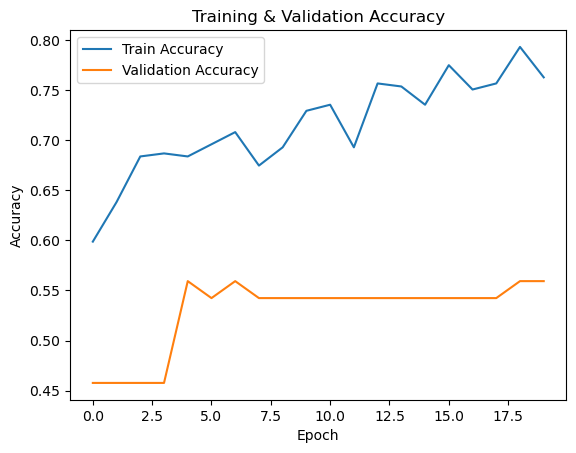

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

In [49]:
model.save(r"C:\Users\pc\Desktop\DiaRet\step4\step4.keras")